# Imports

In [1]:
import h5py
import os
import random

import cv2

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Constants

In [2]:
# for creating reproducible results
SEED = 22
np.random.seed = SEED

# values for images
Y_SPACE = 10
IMG_WIDTH = 512
IMG_HEIGHT = 512

# necessary colours
CLASS_BLACK = (0,0,0)
CLASS_RED = (255,0,0)
CLASS_GREEN = (0,255,0)
CLASS_BLUE = (0,0,255)

# directoy with all hdf5 files, should already exist
HD5_DIRECTORY = './AuswertungMarkerDS/'
# directories to save the results, should be created
IMAGE_DIRECTORY = './data/images/'
MASK_DIRECTORY = './data/masks/'
FILENAME_DIRECTORY = './data/filenames/'

In [3]:
# create all essential directories if they do not exist
if not os.path.exists(IMAGE_DIRECTORY):
    os.makedirs(IMAGE_DIRECTORY)
if not os.path.exists(MASK_DIRECTORY):
    os.makedirs(MASK_DIRECTORY)
if not os.path.exists(FILENAME_DIRECTORY):
    os.makedirs(FILENAME_DIRECTORY)

# Find all HDF5-files

In [4]:
def readHD5Data(directory):
    """Find all HDF5-files in the given directory
    and append them in a list as HDF5 objects with h5py

    Parameters
    ----------
    directory : str
        The directory to be searched

    Returns
    -------
    list
        A list of HDF5-file objects
    """
    
    h5files = []    
    # iterate through the given directory
    for root, dirs, files in os.walk(directory):
        for name in files:
            # bad example since the lines are one pixel too short
            if (name == 'SAPCIMT-20100928-6300078-1952-F-63-1-50000044-634-LCCAH-SC-20101215-ClipResult.h5'):
                continue
            # only use HDF5-files
            elif name.endswith(".h5"):
                # create the correct path
                path = os.path.join(root,name)
                path = path.replace('\\', '/') 
                # read the HDF5-file with h5py and save it in a list
                h5files.append(h5py.File(path, 'r'))
    return h5files

In [5]:
# find HDF5-files
h5files = readHD5Data(HD5_DIRECTORY)
# shuffle the list
random.shuffle(h5files)
# print first five file names to test
for file in h5files[:5]:
    print(file.filename)

./AuswertungMarkerDS/interobserver_good/resultateT1/SAPCIMT-20100831-6302121-1959-M-63--50000044-634-RCCAH-SC-20110311-ClipResult.h5
./AuswertungMarkerDS/interobserver_medium/resultateT1/SAPCIMT-20100902-6701909-1946-M-67-2-50000045-671-LCCAE-SC-20110311-ClipResult.h5
./AuswertungMarkerDS/interobserver_medium/resultateT0/SAPCIMT-20100901-6601595-1947-F-66-2-50000047-664-LCCAE-CM-20110309-ClipResult.h5
./AuswertungMarkerDS/interobserver_medium/resultateT0/SAPCIMT-20100902-6701909-1946-M-67-2-50000045-671-LCCAE-CM-20110309-ClipResult.h5
./AuswertungMarkerDS/interobserver_medium/resultateT0/SAPCIMT-20100902-6101247-1953-M-61-1-50000041-611-RCCAH-SC-20101214-ClipResult.h5


# Create the images and masks

In [6]:
def padImage(desiredShape, image):
    """Pad the given image to the desired shape with a 
    method from OpenCV

    Parameters
    ----------
    desiredShape : tuple
        The desired shape for the given image
    image : numpy-array
        The image which requires padding
        
    Returns
    -------
    numpy-array
        The padded image
    """
    
    # get the old shape
    oldShape = image.shape
    # find out the differences of the shapes
    deltaH = desiredShape[0] - oldShape[0]
    deltaW = desiredShape[1] - oldShape[1]
    # split them evenly
    top, bottom = deltaH//2, deltaH-(deltaH//2)
    left, right = deltaW//2, deltaW-(deltaW//2)
    # pad with opencv
    newImage = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return newImage

In [7]:
def createImagesAndMasks(h5files):
    """Creates the ultrasound images and masks out of the
    given HDF5-files, which contain all necessary data

    Parameters
    ----------
    h5files : list
        List of all HDF5-files which are used for creating
        images and masks
        
    Returns
    -------
    list
        All paths to the created images
    list
        All paths to the created masks
    """
        
    filenamesImages = []
    filenamesMasks = []
    counter = 1
    # for all files
    for h5 in h5files: 
        # get the necessary datasets
        imageSequence = h5['imagedata'] 
        lbNear = h5['lbNearWall']
        liFar = h5['liFarWall']
        maFar = h5['maFarWall']
        
        # only iterate through the necessary slices, which have a imt value
        for i in range(h5.attrs['firstslice'], h5.attrs['lastslice']+1):
            # get the frame
            frame = imageSequence[i]
            # create a mask
            mask = np.zeros(frame.shape, dtype=np.uint8)
            # cut the frame according to the bounding box
            frame = frame[h5.attrs['minYnear']-Y_SPACE:h5.attrs['maxYfar']+Y_SPACE+1, 
                          h5.attrs['begin_1cm']:h5.attrs['begin_1cm']+h5.attrs['bbWidth']+1]
            # all images need to have the same size
            frame = padImage((IMG_WIDTH,IMG_HEIGHT), frame)
            # save it
            np.save(IMAGE_DIRECTORY + h5.filename.split('/')[-3] + "_" + h5.filename.split('/')[-2] + "_" +
                    h5.filename.split('/')[-1] + "_" + str(i), frame)
            filenamesImages.append(h5.filename.split('/')[-3] + "_" + h5.filename.split('/')[-2] + "_" +
                    h5.filename.split('/')[-1] + "_" + str(i) + '.npy')
            
            # iterate over each column of the image in the bounding box
            for j in range(h5.attrs['begin_1cm'], (h5.attrs['begin_1cm']+h5.attrs['bbWidth']+1)):
                # if a value is negative something went wrong
                if(lbNear[i][j] == -1 or liFar[i][j] == -1 or maFar[i][j] == -1):
                    print(h5.filename + f': error in slice {i} at position {j}')
                    continue
                # draw the boundaries into the mask
                else:
                    mask[int(lbNear[i][j]), j] = CLASS_RED
                    mask[int(liFar[i][j]), j] = CLASS_GREEN
                    mask[int(maFar[i][j]), j] = CLASS_BLUE
            # cut the mask according to the bounding box
            mask = mask[h5.attrs['minYnear']-Y_SPACE:h5.attrs['maxYfar']+Y_SPACE+1, 
                        h5.attrs['begin_1cm']:h5.attrs['begin_1cm']+h5.attrs['bbWidth']+1]
            # all masks need to have the same size
            mask = padImage((IMG_WIDTH,IMG_HEIGHT), mask)
            # save it
            np.save(MASK_DIRECTORY + h5.filename.split('/')[-3] + "_" + h5.filename.split('/')[-2] + "_" +
                    h5.filename.split('/')[-1] + "_" + str(i) + '_mask', mask)
            filenamesMasks.append(h5.filename.split('/')[-3] + "_" + h5.filename.split('/')[-2] + "_" +
                    h5.filename.split('/')[-1] + "_" + str(i) + '_mask' + '.npy')
        
        # show the progress
        print(f' {counter} out of ' + str(len(h5files)) + ' files done', end='\r')
        counter += 1
    return filenamesImages, filenamesMasks

In [8]:
# the execution of this cell may take a long time

filenamesImages, filenamesMasks = createImagesAndMasks(h5files)

## Check if the results are correct

In [9]:
# check the structure of the created lists
print(len(filenamesImages))
print(len(filenamesMasks))
print(filenamesImages[:5])
print(filenamesMasks[:5])

532
532
['interobserver_good_resultateT1_SAPCIMT-20100831-6302121-1959-M-63--50000044-634-RCCAH-SC-20110311-ClipResult.h5_127.npy', 'interobserver_good_resultateT1_SAPCIMT-20100831-6302121-1959-M-63--50000044-634-RCCAH-SC-20110311-ClipResult.h5_128.npy', 'interobserver_good_resultateT1_SAPCIMT-20100831-6302121-1959-M-63--50000044-634-RCCAH-SC-20110311-ClipResult.h5_129.npy', 'interobserver_good_resultateT1_SAPCIMT-20100831-6302121-1959-M-63--50000044-634-RCCAH-SC-20110311-ClipResult.h5_130.npy', 'interobserver_good_resultateT1_SAPCIMT-20100831-6302121-1959-M-63--50000044-634-RCCAH-SC-20110311-ClipResult.h5_131.npy']
['interobserver_good_resultateT1_SAPCIMT-20100831-6302121-1959-M-63--50000044-634-RCCAH-SC-20110311-ClipResult.h5_127_mask.npy', 'interobserver_good_resultateT1_SAPCIMT-20100831-6302121-1959-M-63--50000044-634-RCCAH-SC-20110311-ClipResult.h5_128_mask.npy', 'interobserver_good_resultateT1_SAPCIMT-20100831-6302121-1959-M-63--50000044-634-RCCAH-SC-20110311-ClipResult.h5_129_ma

In [10]:
# check a frame
image = np.load(IMAGE_DIRECTORY+filenamesImages[0]) 
mask = np.load(MASK_DIRECTORY+filenamesMasks[0])
print(image.shape)
print(mask.shape)

(512, 512, 3)
(512, 512, 3)


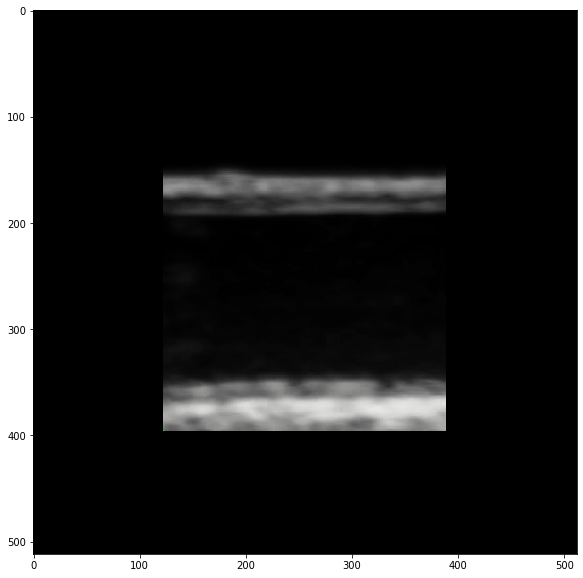

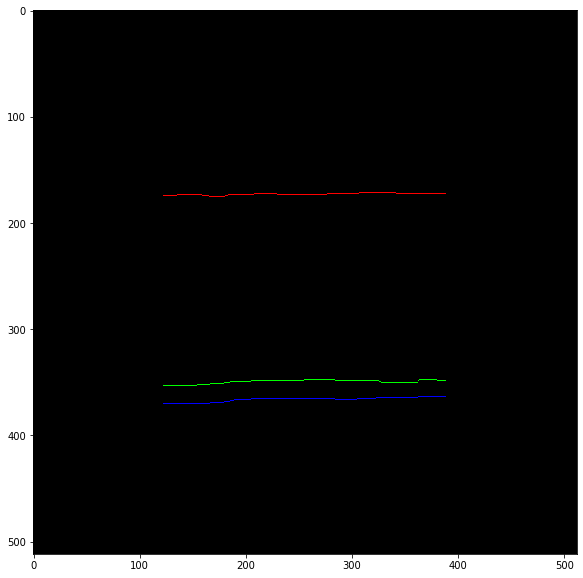

In [11]:
plt.figure(figsize = (10,10))
plt.imshow(image)
plt.figure(figsize = (10,10))
plt.imshow(mask)

# Create a train/test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(filenamesImages, filenamesMasks, 
                                                    test_size=0.2, shuffle=True, random_state = SEED)

print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

425
425
107
107


In [13]:
# save so reproducible results can be created
np.save(FILENAME_DIRECTORY + 'X_train.npy', X_train)
np.save(FILENAME_DIRECTORY + 'y_train.npy', y_train)

np.save(FILENAME_DIRECTORY + 'X_test.npy', X_test)
np.save(FILENAME_DIRECTORY + 'y_test.npy', y_test)